# C4AI Scholars Program Takehome Challenge


### Background

Welcome to the C4AI Scholars Program Take-Home Challenge! This exercise is designed to allow you to showcase your engineering and problem solving skills. The Challenge consists of three parts:

* Part One of the challenge requires identifying bugs, and getting the code working. This is designed to test your ability to grapple with real world engineering challenges.
* Part Two of the challenge tests your ability to generate code for a specified problem.
* Part Three of the challenge is an opportunity for you to attempt an optional challenge question that extends the original problem set.


These tasks were chosen as a setting to see how you think about problems, even if they are not in your own research field of interest. The tasks and dataset are not meant to be indicative of the research goals of the Scholar Program. We purposefully have selected a simple toy problem so the focus is on how you think, and does not require significant machine learning resources.

Good luck! If you have questions about the framing of the questions, please contact info@for.ai  


### How to Use and Submit this Document

* **Make a copy of this document** and **rename** it **Firstname_Lastname_C4AIScholarsChallenge**
* Once you’ve completed all tasks, **save and pin your revisions**
* **Submit a link** to your final document via the [Cohere For AI Scholars Program application](https://jobs.lever.co/cohere/?department=Cohere%20For%20AI).



---



## Overview of Singular Value Decomposition

In this takehome, you will be working on a problem involving singular value decomposition. Singular Value Decomposition (SVD) exists for every rectangular matrix. The nice thing about SVD is that the original matrix can be expressed as the sum of outer products of left and singular vectors scaled by the corresponding singular values. Formally:

> Let 𝛢 be a rectangular matrix of dimensions 𝑚𝘹𝑛, then the SVD of the matrix A is given by $ A = U𝛴V^T$ where $U$ is an orthogonal matrix of shape mxm containing the left singular vectors, $V$ is an orthogonal matrix of shape nxn containing the right singular vectors and $𝛴$ is a diagonal matrix containing the singular values of $A$. This formulation of SVD can be re-expressed as \begin{align} A = \sum_{i=1}^{r} s_i. u_i v_i^T \end{align} where $r = \text{min}(m,n)$ represents the rank of the matrix, $s_i$ is the $i$th singular value and $u_i v_i^T$ is the outer product of the $i$th left and right singular vectors.

<!-- \begin{align}
A = \sum_{i=1}^{\text{min}(m,n)} s_i. u_i v_i^T
\end{align}
\begin{align} -->

> The singular values $𝛴$ are decreasing in order. So, each outer product is scaled by a smaller value as we compute each term in the sum above. This gives us an opportunity to approximate $A$ using only the sum of the first $k$ outer products where $k < \text{min}(m,n)$ $-$ this effectively means that we are zero-ing out some of the singular values by assuming that the contribution to the sum is negligible. This is called low-rank approximation.

If you aren't familiar with singular value decomposition, or the above feels rusty, don't worry. Take a moment to brush up your knowledge using any of the following resources:
* [stanford lecture notes on low rank approximations](https://web.stanford.edu/class/cs168/l/l9.pdf)
* [youtube series of short and beginner friendly lectures](https://www.youtube.com/watch?v=gXbThCXjZFM&list=PLMrJAkhIeNNSVjnsviglFoY2nXildDCcv)



## Check for understanding (3 points)

#### Q1: What are some real world applications of low rank approximations?


#### Answer:


1. Deep Neural Network compression: Compression of deep neural networks helps in reducing the size of the neural network and reducing computations to improve inference time for the network. Cost benefits and lower environmental impact from lower compute needs.
2. Image Lossy Compression: Low-rank decompositions help in generating lossy compression of images, which are good approximations for the original image
3. Collaborative filtering in recommender systems: We make predictions about a user's interests by collating information about the claims of other users.   
4. Image denoising: Low-rank approximations are used to remove noise to generate a better-quality image



#### Q2: What are the benefits of compressing a deep neural network? How would you measure the benefits of compression?


#### Answer:


Benefits of compressing a deep neural network
*   Reduction in size of the network due to fewer parameters. This results in a smaller memory footprint and allows models to run on resource-constrained machines. This makes these models accessible to a larger audience
*   Improvement in inference time due to fewer computations.
*   Reduced energy requirements to run a model, resulting in lower costs and less environmental impact
* Reduction in training time, models with half-precision take considerably less time to train

Measure benefits due to compression
*   Model size can be measured. It should be considerably less compared to the original model. This is similar to measuring the number of parameters in the networks
*   Counting the number of flops to make an inference, or measuring average inference time to run the model
*   Measuring compute costs for a model in production





#### Q3: In this takehome, we will consider how singular value decomposition can be used to compress a deep neural network. Compared to other compression methods used for deep neural networks such as pruning, quantization, or efficient architectures, what are the relative merits/demerits of low rank approximations? Choose one or two alternative compression methods and compare with singular value decomposition.

#### Answer:

Merits:


*   Cheap way to compress an over-parameterized model: decomposition is typically done layer by layer. In addition to computing the decomposition matrices, we simply need to redefine the model architecture with the new weights
*   SVD low-rank approximation doesn't need retraining, fine-tuning may improve performance
*   Generates models that have good performance with a smaller number of parameters and a lower number of floating point operations although they will have more layers. Especially, in the case of SVD when the number of singular values chosen is << then the rank of the matrix
*   Smaller models can be deployed to resource-constrained machines without any need for specialized support

Demerits:
*   Approach cannot be used to improve training time, we need a pre-trained over-parameterized model, to begin with
*   Only linear Deep Neural Network layers like convolution (tucker and cp decomposition) and fully connected layers benefit, algorithms ignore the nonlinearity that comes after them
*   SVD decomposition works layer by layer ignoring interactions between layers. In that sense, they are greedy and maybe sub-optimal
---

Comparing SVD with Pruning and efficient architectures


* Efficient architectures are the go-to technique when we need to train a model from scratch. Unlike, SVD and Pruning we don't require a pre-trained model

* Pruning typically requires multiple forward and backward passes on the model using the data to effectively perform model compression

* Low-rank approximations seem like the fastest way to achieve a compressed model, we just need to redefine the model arch in a specific way and compute the decompositions.

* Pruning and efficient architecture for a problem achieve model compression by learning from the data in a global sense, as opposed to SVD which greedily picks up a layer and does the decomposition

* Most Pruning algorithms need specialized support to improve inference time, currently libraries' support for sparse tensor operations seems limited. Libraries like PyTorch use masking at runtime to implement pruning but this will not help the runtime performance of the model







---



### Imports

In [ ]:
!pip install dm-haiku optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 350 kB 27.3 MB/s 
     |████████████████████████████████| 145 kB 63.6 MB/s 
     |████████████████████████████████| 85 kB 5.2 MB/s 


In [ ]:
from typing import Iterator, Mapping, Tuple
from copy import deepcopy
import time
from absl import app
import haiku as hk
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow_datasets as tfds
import tensorflow as tf
from functools import partial
import math

Batch = Tuple[np.ndarray, np.ndarray]



---




## Coding Challenge Part I : Debugging Challenge (10 Points)


We are now going to explore using SVD to compute low rank approximations of the parameters of a small deep neural network. You are using a very simple toy model as a first baseline. Section 3 will give you the chance to improve baseline accuracy beyond this very simple model -- this is just a toy setting to first explore low rank approximations.

The first part of this challenge is primarily a debugging challenge. It will require removing bugs in order to train a very simple network. We have introduced several bugs -- some are subtle and will not break your code but will degrade final performance. These subtle bugs are introduced to understand your grasp of fundamental machine learning principles. There are also more obvious bugs designed to break your code.

* [**4 points**] Your goal is to get the code working. There are 4 bugs in the code, all 4 of these are subtle bugs which are designed to impair test accuracy but not break the code. You will get partial points for each of the 4 bugs you find. After finding all bugs, your test performance should be around 66-67% test accuracy.

* [**2 points**] We will give extra points for also adding improved documentation to each of the functions we introduce in this section, and for describing the fixes to the bugs.

* [**4 points**] There are also two functions you will need to code up in this section -- we indicate where these code changes need to happen with TODO comments.

* Do not alter the model architecture or the learning rate.


Useful tips:
* To iterate faster and avoid training for 10000 steps each time you want to test whether you have found all the bugs, a good sign you have caught the bugs is wheter after 1000/10000 steps your accuracy >40%.
* The colab difftool is useful to track what code you have changed during the debugging challenge (incase you need to revert code). You can access this via tools > diff notebooks.

In [ ]:
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2023, 0.1994, 0.2010)


def net_fn(batch: Batch) -> jnp.ndarray:
  """Defines the network"""
  x = normalize(batch[0])

  # Do NOT alter the architecture definition below.
  net = hk.Sequential([
      hk.Conv2D(output_channels=6*3, kernel_shape=(5,5)),
      jax.nn.relu,
      hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
      jax.nn.relu,
      hk.Conv2D(output_channels=16*3, kernel_shape=(5,5)),
      jax.nn.relu,
      hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
      hk.Flatten(),
      hk.Linear(3000), jax.nn.relu,
      hk.Linear(2000), jax.nn.relu,
      hk.Linear(2000), jax.nn.relu,
      hk.Linear(1000), jax.nn.relu,
      hk.Linear(10),
  ])
  return net(x)

def load_dataset(
    split: str,
    *,
    is_training: bool,
    batch_size: int,
) -> Iterator[tuple]:
  """Loads the dataset as a generator of batches."""
  # cache the dataset to memory and repeat it indefinitely, epochs have reshuffled ordered data since *reshuffle_each_iteration* defaults to TRUE
  ds = tfds.load('cifar10', split=split, as_supervised=True).cache().repeat()
  if is_training:
    # shuffle the batches to improve generalization of the trained network
    ds = ds.shuffle(10 * batch_size, seed=0)
  ds = ds.batch(batch_size)
  return iter(tfds.as_numpy(ds))

# Recommended: this can be jit'd and it should result in faster training time
# @jax.jit
def compute_loss(params: hk.Params, batch: Batch) -> jnp.ndarray:
  """Compute the loss of the network, including L2."""
  x, y = batch
  logits = net.apply(params, batch)
  labels = jax.nn.one_hot(y, 10)

  # DONE: TODO: add code below to compute the l2_loss variable
  param_values = jax.tree_util.tree_leaves(params)
  l2_loss = sum(jnp.sum(jnp.square(value)) for value in param_values)

  weighted_l2_loss = 0.5 * l2_loss

  # NOT A BUG: usually we take mean of the loss, but since the loss is usually adjusted by a scaling factor it's effectively equivalent
  # I am not taking mean of the loss here, since there are some scale issues between l2 loss and cross entropy loss that need to be adjusted
  softmax_xent = -jnp.sum(jnp.multiply(labels, jax.nn.log_softmax(logits)))

  # BUG 1: l2 loss should be added to the xent loss instead of being subtracted,
  # BUG 2: we should be using the weighted l2 loss here
  # subtracting will encourage network params with large l2 norms and would impair training progress
  return softmax_xent + (1e-4 * weighted_l2_loss)


@jax.jit
def compute_accuracy(params: hk.Params, batch: Batch) -> jnp.ndarray:
  """Compute prediction accuracy for a batch of data"""
  # using the global. the correct net gets binded to the params.
  # Every time the shape of the params change, it triggers a JIT compile and JIT binds the net function
  # https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#pure-functions
  predictions = net.apply(params, batch)

  # DONE:: TODO: add code below to compute the accuracy over the batch.
  _, y = batch
  prediction_label = jnp.argmax(predictions, axis=1)
  # using the jax.lax equals method here to avoid recompilations
  # https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#structured-control-flow-primitives
  accuracy = jnp.mean(jnp.equal(prediction_label,y))

  return accuracy

@jax.jit
def update(
    params: hk.Params,
    opt_state: optax.OptState,
    batch: Batch,
) -> Tuple[hk.Params, optax.OptState]:
  """Compute gradients and update the weights"""
  grads = jax.grad(compute_loss)(params, batch)
  updates, opt_state = opt.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, opt_state

@jax.jit
def ema_update(params, avg_params):
  """Incrementally update parameters via polyak averaging."""
  # Polyak averaging tracks an (exponential moving) average of the past parameters of a model, for use at test/evaluation time.
  return optax.incremental_update(params, avg_params, step_size=0.001)


def normalize(images):
  # numpy array creation could be moved out of the method
  mean = np.asarray(CIFAR10_MEAN)
  std = np.asarray(CIFAR10_STD)

  # BUG 3: int8 range is -128 to 127 causing issues with numbers > 127, uint8 / 255. is float64, casting as float32 since that's the type jax prefers
  x = images.astype(jnp.float32) / 255.

  # BUG 4: x /- mean just divides x by -1. * mean without reassignment to x
  x -= mean  # operations uses numpy broadcasting to work correctly
  x /= std

  return x

### Training

In [ ]:
net = hk.without_apply_rng(hk.transform(net_fn))

# Do not change learning rate
opt = optax.adam(1e-3)

# using 20% of the dataset for training, 80% for validation, although it's weird to use maximum available data for validation
# BUG: using 80% train data, since performance improvement beyond 50% wasn't seen with 20% train data
train = load_dataset("train[:80%]", is_training=True, batch_size=1000)
validation = load_dataset("train[80%:]", is_training=False, batch_size=10000)

test = load_dataset("test", is_training=False, batch_size=10000)

# Alternative: supplying a dummy data instead of actual data for Haiku to init the network
# dummy_data = jnp.ones([100, 32, 32, 3]), 1

# Recommended: param objects should be deepcopied, although in this case it doesn't cause issues
# we draw an input to get shapes.
params = net.init(jax.random.PRNGKey(42), next(train))
avg_params = deepcopy(params)
opt_state = opt.init(params)

# Do not alter the number of steps
for step in range(10001):
  if step % 1000 == 0:
    val_accuracy = compute_accuracy(avg_params, next(validation))
    test_accuracy = compute_accuracy(avg_params, next(test))
    val_accuracy, test_accuracy = jax.device_get(
        (val_accuracy, test_accuracy))
    print(f"[Step {step}] Validation / Test accuracy: "
          f"{val_accuracy:.3f} / {test_accuracy:.3f}.")

  params, opt_state = update(params, opt_state, next(train))
  avg_params = ema_update(params, avg_params)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteH429IC/cifar10-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteH429IC/cifar10-test.tfrecord*...:   0%|          | 0/1…

Dataset cifar10 downloaded and prepared to ~/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
[Step 0] Validation / Test accuracy: 0.101 / 0.103.
[Step 1000] Validation / Test accuracy: 0.468 / 0.469.
[Step 2000] Validation / Test accuracy: 0.605 / 0.612.
[Step 3000] Validation / Test accuracy: 0.619 / 0.625.
[Step 4000] Validation / Test accuracy: 0.624 / 0.630.
[Step 5000] Validation / Test accuracy: 0.621 / 0.630.
[Step 6000] Validation / Test accuracy: 0.623 / 0.630.
[Step 7000] Validation / Test accuracy: 0.625 / 0.628.
[Step 8000] Validation / Test accuracy: 0.625 / 0.627.
[Step 9000] Validation / Test accuracy: 0.623 / 0.627.
[Step 10000] Validation / Test accuracy: 0.623 / 0.626.




---



## Coding Challenge Part 2: Compression through Low Rank Approximation (8 points)

In this section, you will add code to compute the low rank approximation and to compute evaluation metrics. We will evaluate whether the low rank approximation allows for speed up in inference time. We define inference time as the average time to compute the prediction for all examples in the test set.

* [**4 points**] You will need to add code to define both the compute_eval_metrics and rank_approximated weight function.
* [**4 points**] Q4 and Q5 are worth 2 points each.

In [ ]:
import timeit

@jax.jit
def apply_(params: hk.Params, batch: Batch) -> jnp.ndarray:
  """Get predictions from the network"""
  # this function will get compiled only once for Q2 but will compile 10 times for Q3 and Q4. Each new net function triggers recompilation
  # https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#pure-functions

  # net is a global
  predictions = net.apply(params, batch)
  return predictions

@jax.jit
def accuracy_(predictions: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
  """Compute accuracy from the predictions"""
  prediction_label = jnp.argmax(predictions, axis=1)
  accuracy = jnp.mean(jnp.equal(prediction_label, y))

  return accuracy

def compute_accuracy(params: hk.Params, batch: Batch) -> Tuple[jnp.ndarray, jnp.ndarray]:
  # adding timer to this method
  start = timeit.default_timer()
  # adding block until ready to measure correct time
  predictions = apply_(params, batch).block_until_ready()
  duration = timeit.default_timer() - start

  # DONE:: TODO: add code below to compute the accuracy over the batch.
  _, y = batch
  accuracy = accuracy_(predictions, y)

  return accuracy, duration

def compute_eval_metrics(params, batch, n_samples):
# DONE: TODO: add code to compute the time for inference.
  duration_list = []
  accuracy_list = []
  for _ in range(n_samples):
    # DONE: Added above, TODO: add code to correctly compute the accuracy on a given batch.
    acc, duration = compute_accuracy(params, batch)
    duration_list.append(duration)
    accuracy_list.append(acc)

  return accuracy_list, duration_list

In [ ]:
def rank_approximated_weight(weight: jnp.ndarray, rank_fraction: float):
  U, a, V = jnp.linalg.svd(weight)
  # DONE: TODO: replace the code below with code to compute the SVD of the matrix to return the rank approximated weights u and v for a given matrix.
  # u = jax.random.normal(jax.random.PRNGKey(42), shape=weight.shape)
  # size = weight.shape[1]
  # v = jax.random.normal(jax.random.PRNGKey(42), shape=(size,size))
  m, n = weight.shape

  if n > m:
    rank = m
  else:
    # default case where m >= n
    rank = n

  k = (rank * rank_fraction).astype(int)
  diag_matrix = jnp.diag(a[:k])
  V = diag_matrix@V[:k, :]

  return U[:, :k], V

### Evaluations at different ranks

The code below first replaces the weights with the low rank factorizations at different rank fractions. For each modified net, we compute the new eval accuracy. Firstly, add code for the rank_approximated_weight and add code to correctly compute the time for inference (the duration).

In [ ]:
# BUG: we should be copying avg_params and not params
params = deepcopy(avg_params)
rank_truncated_params = deepcopy(params)
ranks_and_accuracies = []
ranks_and_times = []
for rank_fraction in np.arange(1.0, 0.0, -0.1):

  print(f"Evaluating the model at {rank_fraction}")
  for layer in params.keys():
    if 'conv' in layer:
      continue
    weight = params[layer]['w']
    # DONE: TODO: complete coding the rank_approximated_weight function to compute the SVD of the matrix to return the rank approximated weights u and v for a given matrix.
    u, v = rank_approximated_weight(weight, rank_fraction)
    rank_truncated_params[layer]['w'] = u@v

  test_batch = next(test)
  # we compute metrics over 50 samples to reduce noise in the measurement.
  n_samples = 50
  # DONE: TODO: complete coding the compute_eval_metrics function to compute the time taken for inference.
  test_accuracy, latency = compute_eval_metrics(rank_truncated_params, next(test), n_samples)
  print(f"Rank Fraction / Test accuracy: "
          f"{rank_fraction:.2f} / {np.mean(test_accuracy):.3f}.")
  ranks_and_accuracies.append((rank_fraction, np.mean(test_accuracy)))
  print(f"Rank Fraction / Duration (milli sec): "
          f"{rank_fraction:.2f} / {np.mean(latency)*1000:.4f}.")
  ranks_and_times.append((rank_fraction, np.mean(latency)))

Evaluating the model at 1.0
Rank Fraction / Test accuracy: 1.00 / 0.626.
Rank Fraction / Duration (milli sec): 1.00 / 214.8488.
Evaluating the model at 0.9
Rank Fraction / Test accuracy: 0.90 / 0.626.
Rank Fraction / Duration (milli sec): 0.90 / 209.3016.
Evaluating the model at 0.8
Rank Fraction / Test accuracy: 0.80 / 0.625.
Rank Fraction / Duration (milli sec): 0.80 / 208.5936.
Evaluating the model at 0.7000000000000001
Rank Fraction / Test accuracy: 0.70 / 0.614.
Rank Fraction / Duration (milli sec): 0.70 / 209.3766.
Evaluating the model at 0.6000000000000001
Rank Fraction / Test accuracy: 0.60 / 0.617.
Rank Fraction / Duration (milli sec): 0.60 / 209.3382.
Evaluating the model at 0.5000000000000001
Rank Fraction / Test accuracy: 0.50 / 0.616.
Rank Fraction / Duration (milli sec): 0.50 / 209.0742.
Evaluating the model at 0.40000000000000013
Rank Fraction / Test accuracy: 0.40 / 0.581.
Rank Fraction / Duration (milli sec): 0.40 / 208.7761.
Evaluating the model at 0.30000000000000016

### Q4: What do you observe as the relationship between rank fraction and test accuracy?

Plot this relationship showing accuracy (y-axis) vs rank percentage of the matrix (x-axis). You should use the ranks_and_accuracies list computed above.

Answer: The test accuracy is comparable to accuracy on the full network and starts significantly dropping as the rank fraction dips below 0.5

Text(0, 0.5, 'Accuracy')

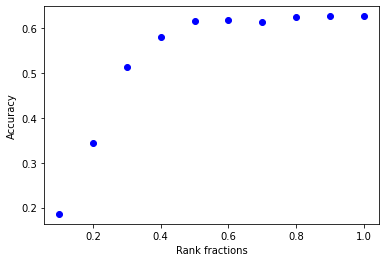

In [ ]:
## DONE: TODO: add your code below to plot the relationship between time and test set accuracy

from matplotlib import pyplot as plt

x = [x for x, _ in ranks_and_accuracies]
y = [y for _, y in ranks_and_accuracies]

plt.plot(x, y, 'bo')
plt.xlabel("Rank fractions")
plt.ylabel("Accuracy")

### Q5: Does replacing the weight matrix with the low factor matrix result in latency speed ups?

Plot the relationship of time (y-axis) vs rank percentage (x-axis). To do so add code to compute the ranks_and_times list.

Answer: No, Latency is similar to latency on the full matrix, this is because the number of multiplications required to do inference remains the same in this implementation. The latency at rank fraction 1 is marginally higher becuase of jit comilation, which happens when the first inference is done.

Text(0, 0.5, 'Time taken for infence in milli-seconds')

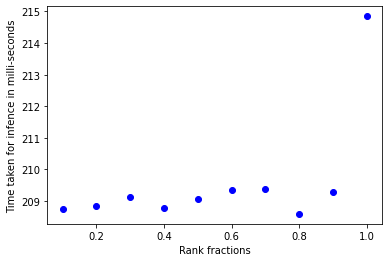

In [ ]:
## DONE: TODO: add your code below to plot the relationship between time and rank percentage

x = [x for x, _ in ranks_and_times]
y = [y*1000 for _, y in ranks_and_times]


plt.plot(x, y, 'bo')
plt.xlabel("Rank fractions")
plt.ylabel("Time taken for infence in milli-seconds")

## Coding Challenge Part 3: Perform evaluations on the dataset in factorized space. (4 points)

In this section, you will perform evaluations on the dataset in factorized space.

* [**4 points**] 2 pts for question 6 and question 7.

In [ ]:
def low_rank_net_fn(batch: Batch, rank: float) -> jnp.ndarray:

  x = normalize(batch[0])

  total_input_dim = np.prod(x.shape[1:])

  # Do not alter the architecture code.
  net = hk.Sequential([
      hk.Conv2D(output_channels=6*3, kernel_shape=(5,5)),
      jax.nn.relu,
      hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
      jax.nn.relu,
      hk.Conv2D(output_channels=16*3, kernel_shape=(5,5)),
      jax.nn.relu,
      hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
      hk.Flatten(),
      hk.Linear(int(rank * min(total_input_dim, 3000)), with_bias=False),
      hk.Linear(3000), jax.nn.relu,
      hk.Linear(int(rank * 2000), with_bias=False),
      hk.Linear(2000), jax.nn.relu,
      hk.Linear(int(rank * 2000), with_bias=False),
      hk.Linear(2000), jax.nn.relu,
      hk.Linear(int(rank * 1000), with_bias=False),
      hk.Linear(1000), jax.nn.relu,
      hk.Linear(int(rank * 10), with_bias=False),
      hk.Linear(10),
  ])
  return net(x)

In [ ]:
vanilla_to_low_rank_map = {
    'conv2_d': 'conv2_d',
    'conv2_d_1': 'conv2_d_1',
    'linear': ['linear', 'linear_1'],
    'linear_1': ['linear_2', 'linear_3'],
    'linear_2': ['linear_4', 'linear_5'],
    'linear_3': ['linear_6', 'linear_7'],
    'linear_4': ['linear_8', 'linear_9']
}


ranks_and_accuracies = []
ranks_and_times = []
for rank_fraction in np.arange(1.0, 0.0, -0.1):
  low_rank_net_fn_partial = partial(low_rank_net_fn, rank=rank_fraction)
  net = hk.without_apply_rng(hk.transform(low_rank_net_fn_partial))
  low_rank_params = net.init(jax.random.PRNGKey(42), next(train))

  print(f"Evaluating the model at " f"{rank_fraction:.2f}")

  for layer in vanilla_to_low_rank_map.keys():
    if 'conv' in layer:
      low_rank_params[layer] = params[layer]
      continue
    weight = params[layer]['w']
    # TODO: complete coding the rank_approximated_weight function to compute the SVD of the matrix to return the rank approximated weights u and v for a given matrix.
    u, v = rank_approximated_weight(weight, rank_fraction)
    low_rank_params[vanilla_to_low_rank_map[layer][0]]['w'] = u
    low_rank_params[vanilla_to_low_rank_map[layer][1]]['w'] = v
    low_rank_params[vanilla_to_low_rank_map[layer][1]]['b'] = params[layer]['b']

  # TODO: modify the compute_eval_metrics function below to compute the time taken for inference.
  test_accuracy, duration = compute_eval_metrics(low_rank_params, next(test), 50)
  ranks_and_times.append((rank_fraction, np.mean(duration)))
  ranks_and_accuracies.append((rank_fraction, np.mean(test_accuracy)))
  print(f"Rank Fraction / Test accuracy: "
          f"{rank_fraction:.2f} / {np.mean(test_accuracy):.3f}.")
  print(f"Rank Fraction / Duration (milli sec): "
          f"{rank_fraction:.2f} / {np.mean(duration)*1000:.4f}.")

Evaluating the model at 1.00
Rank Fraction / Test accuracy: 1.00 / 0.626.
Rank Fraction / Duration (milli sec): 1.00 / 448.5849.
Evaluating the model at 0.90
Rank Fraction / Test accuracy: 0.90 / 0.626.
Rank Fraction / Duration (milli sec): 0.90 / 450.0596.
Evaluating the model at 0.80
Rank Fraction / Test accuracy: 0.80 / 0.625.
Rank Fraction / Duration (milli sec): 0.80 / 405.1707.
Evaluating the model at 0.70
Rank Fraction / Test accuracy: 0.70 / 0.614.
Rank Fraction / Duration (milli sec): 0.70 / 373.9225.
Evaluating the model at 0.60
Rank Fraction / Test accuracy: 0.60 / 0.617.
Rank Fraction / Duration (milli sec): 0.60 / 335.1806.
Evaluating the model at 0.50
Rank Fraction / Test accuracy: 0.50 / 0.616.
Rank Fraction / Duration (milli sec): 0.50 / 298.5186.
Evaluating the model at 0.40
Rank Fraction / Test accuracy: 0.40 / 0.581.
Rank Fraction / Duration (milli sec): 0.40 / 264.1593.
Evaluating the model at 0.30
Rank Fraction / Test accuracy: 0.30 / 0.513.
Rank Fraction / Duratio

### Q6: Plot a curve showing time vs rank percentage of the matrix

Text(0, 0.5, 'Time taken for infence in milli-seconds')

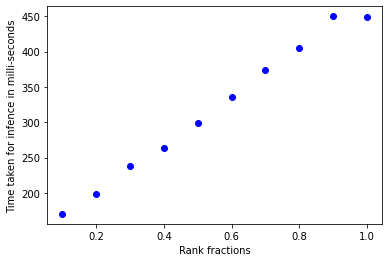

In [ ]:
# DONE: TODO: add code to plot the relationship between time vs percentage rank of the matrix.

x = [x for x, _ in ranks_and_times]
y = [y*1000 for _, y in ranks_and_times]

plt.plot(x, y, 'bo')
plt.xlabel("Rank fractions")
plt.ylabel("Time taken for infence in milli-seconds")

### Q7: What do you observe between time and the percentage rank of the matrix.

### Put your answer here:


*   We see a linear drop-off in latency over each iteration. This is in relation to what is expected --


Maths Working Below:
```
(naive algorithm for multiplication)
x*U where u has dimension (n,o) and x has dimensions (m, n) will require
(2n-1)*m*o operations

decomposing U into u and v with dimensions (n, a), (a, o)
x*u*v will require (2n -1)*a*m + (2a-1)*m*o

which is approximately equal to 2n*a*m + 2a*m*o = 2a*m(o+n)  (since 2a>>1 and 2n>>1)
number of multiplications decrease linearly compared with size of a
```


*   When rank_fraction is greater than 0.3 we see inference time of the model is comparable to the network where no decomposition was done. ie > 200ms

```
Using our equations from earlier we see

Without SVD we take approx 2n*m*o operations
After SVD we take approx 2a*m*(o+n)

a == frac*n; After SVD we have 2*frac*n*o*m + 2*frac*n*m*n
```

**consider the following:**

n is larger then o, then number of operations after SVD is still high,

Maths Working Below:
```
in our network for the linear layers n is 2x to x times o
(Linear layers are (6000+,3000), (3000, 2000), (2000, 2000), (2000, 1000)

setting n as 2*o and frac as 0.5 we have
After SVD -- n*o*m + 2*n*m*o = 3*m*n*o
Note: Before SVD we needed 2*m*n*o operations, so in this case we have a 50% increase in latency
```



---



## Coding Challenge Part 4: Take this Further (10 bonus points)

This part of the challenge is designed to be open ended. If you wanted to show some more skills, here is your chance to shine. We include two options below -- **only do one of the options**:

**Option 1:** Implement a change that isn't SVD but minimizes inference latency while preserving accuracy. Can you outperform SVD?



**Option 2:** Improve the quality of code for this takehome. Pretend you are reviewing a peer and add comments to cells with suggestions of how to improve the code quality. Try and make your comments action orientated and precise.


**For Option 1, DO NOT alter the previous code sections, instead add any new code below. You should not need to add new code for Option 2, instead just add comments to cells.**


## Structured Iterative Pruning on Linear Layers

### Algorithm

1. While validation_accuracy dips below threshold:
> 1. Reduce neurons according to a schedule -- only linear layers since we have large linear layers
> 2. Fine-tune train pruned network
> 3. Measure validation accuracy

2. Measure test accuracy
3. Measure inference time

### Depth Separable Convolutions (Other attempt)
<s> Depth Separable Convolutions, will reduce inference time for convolutions </s>

Dropped the idea as it's not in the spirit of model compression,

Also, it's difficult to identify the right arch and train the model to desired accuracy and latency





In [ ]:
# This works as expected because, the correct net gets binded to the params do to jit compiling behavior
orig_accuracy, _ = compute_accuracy(avg_params, next(validation))
threshold_on_accuracy = 0.1

desired_accuracy = (1 - threshold_on_accuracy) * orig_accuracy
params_fin = deepcopy(avg_params)

In [ ]:
def l2_structured_pruning(b: jnp.ndarray, weights_in: jnp.ndarray, weights_out: jnp.ndarray, sparse_fraction: float, algo="in"):
  """Identify neurons that have small weights and manipulate weight matrices accordingly"""

  if algo == "in":
    # using incoming weights for the neuron
    norms = jnp.linalg.norm(weights_in, ord=2, axis=0)
    indices = jnp.argsort(norms)
    k = int((1-sparse_fraction) * jnp.size(norms))
    print(jnp.size(norms), " neurons reduced to ", k)
    keep_indices = jnp.greater_equal(np.arange(norms.size), norms.size - k)
    weights_in_fin = weights_in[:, keep_indices]
    weights_out_fin = weights_out[keep_indices, :]
    b_fin = b[keep_indices]

  if algo == "in_out":
    # using incoming and outgoing weights for the neuron
    norms1 = jnp.linalg.norm(weights_in, ord=2, axis=0)
    norms2 = jnp.linalg.norm(weights_out, ord=2, axis=1)
    norms = norms1*norms2
    indices = jnp.argsort(norms)
    k = int((1-sparse_fraction) * jnp.size(norms))
    print(jnp.size(norms), " neurons reduced to ", k)
    keep_indices = jnp.greater_equal(np.arange(norms.size), norms.size - k)
    weights_in_fin = weights_in[:, keep_indices]
    weights_out_fin = weights_out[keep_indices, :]
    b_fin = b[keep_indices]

  return b_fin, weights_in_fin, weights_out_fin

In [ ]:
def sparse_net_fn(batch: Batch, sparsity_fractions: jnp.ndarray, iteration: jnp.int8) -> jnp.ndarray:

  x = normalize(batch[0])

  total_input_dim = np.prod(x.shape[1:])
  l1 = 3000
  l2 = 2000
  l3 = 2000
  l4 = 1000
  # calculate sizes for each layer
  for i in np.arange(iteration):
    l1 = int((1-sparsity_fractions[2])*l1)
    l2 = int((1-sparsity_fractions[3])*l2)
    l3 = int((1-sparsity_fractions[4])*l3)
    l4 = int((1-sparsity_fractions[5])*l4)

  # Do not alter the architecture code.
  net = hk.Sequential([
      hk.Conv2D(output_channels=int((1-sparsity_fractions[0]) * 6*3), kernel_shape=(5,5)),
      jax.nn.relu,
      hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
      jax.nn.relu,
      hk.Conv2D(output_channels=int((1-sparsity_fractions[1]) * 16*3), kernel_shape=(5,5)),
      jax.nn.relu,
      hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
      hk.Flatten(),
      hk.Linear(l1), jax.nn.relu,
      hk.Linear(l2), jax.nn.relu,
      hk.Linear(l3), jax.nn.relu,
      hk.Linear(l4), jax.nn.relu,
      hk.Linear(10),
  ])
  return net(x)

In [ ]:
# % removal of neurons at each layer in each pruning iteration
# only pruning linear layers, research has shown that the deeper layers have more tendency to be sparse, so pruning deeper layers aggressively
layer_to_sparseness_map = [
    ('conv2_d', 0.),
    ('conv2_d_1', 0.),
    ('linear', .08),
    ('linear_1', .08),
    ('linear_2', .12),
    ('linear_3', .12),
    ('linear_4', 0.),
]
params = deepcopy(avg_params)
layers = [x for x, _ in layer_to_sparseness_map]
sparsity_fractions = [y for _, y in layer_to_sparseness_map]

iteration = 0
params_list = []
# without any sparsity
params_list.append(avg_params)
val_accuracy = 1.0 #initialization
while val_accuracy > desired_accuracy:
  iteration+=1

  sparse_net_fn_partial = partial(sparse_net_fn, sparsity_fractions=sparsity_fractions, iteration=iteration)
  net = hk.without_apply_rng(hk.transform(sparse_net_fn_partial))
  sparse_net_fn_params = net.init(jax.random.PRNGKey(42), next(train))

  print(f"Evaluating the model at iteration " f"{iteration:.0f}")

  for i in np.arange(len(layers)-1):
    layer = layers[i]
    if 'conv' in layer: #last layer or conv layers
      sparse_net_fn_params[layer] = params[layer]
      continue

    layer_next = layers[i+1]

    weight_in_ = params[layer]['w']
    weight_out_ = params[layer_next]['w']
    b_ = params[layer]['b']

    b, weights_in, weights_out = l2_structured_pruning(b_, weight_in_, weight_out_, sparsity_fractions[i], algo="in")

    # manipulating the weights to effect pruning
    # updating new weights in params for next iteration
    params[layer]['w'] = sparse_net_fn_params[layer]['w'] = weights_in
    sparse_net_fn_params[layer]['b'] = b
    params[layer_next]['w'] = sparse_net_fn_params[layer_next]['w'] = weights_out
    sparse_net_fn_params[layer_next]['b'] = params[layer_next]['b']

  # train model
  sparse_net_fn_avg_params = deepcopy(sparse_net_fn_params)
  opt_state = opt.init(sparse_net_fn_params)

  # fine tuning the pruned network
  for step in range(501):
    if step % 500 == 0:
      val_accuracy, _ = compute_accuracy(sparse_net_fn_avg_params, next(validation))
      test_accuracy, _ = compute_accuracy(sparse_net_fn_avg_params, next(test))
      val_accuracy, test_accuracy = jax.device_get(
          (val_accuracy, test_accuracy))
      print(f"[Step {step}] Validation / Test accuracy: "
            f"{val_accuracy:.3f} / {test_accuracy:.3f}.")

    sparse_net_fn_params, opt_state = update(sparse_net_fn_params, opt_state, next(train))
    sparse_net_fn_avg_params = ema_update(sparse_net_fn_params, sparse_net_fn_avg_params)

  # updating params for next iteration of pruning
  params = deepcopy(sparse_net_fn_avg_params)

  # params with sparsity at pruning iteration i
  params_list.append(sparse_net_fn_avg_params)

ranks_and_accuracies = []
ranks_and_times = []
# measuring accuracy and latency
for i in range(len(params_list)):
  params_ = params_list[i]
  # This works as expected because, the correct net gets binded to the params do to jit compiling behavior
  test_accuracy, duration = compute_eval_metrics(params_, next(test), 50)
  print(f"Pruning Iteration / Test accuracy: "
          f"{i:.0f} / {np.mean(test_accuracy):.3f}.")
  ranks_and_accuracies.append((i, np.mean(test_accuracy)))
  print(f"Pruning Iteration / Duration (milli sec): "
          f"{i:.0f} / {np.mean(duration)*1000:.4f}.")
  ranks_and_times.append((i, np.mean(duration)))

Evaluating the model at iteration 1
3000  neurons reduced to  2760
2000  neurons reduced to  1840
2000  neurons reduced to  1760
1000  neurons reduced to  880
[Step 0] Validation / Test accuracy: 0.617 / 0.615.
[Step 500] Validation / Test accuracy: 0.620 / 0.620.
Evaluating the model at iteration 2
2760  neurons reduced to  2539
1840  neurons reduced to  1692
1760  neurons reduced to  1548
880  neurons reduced to  774
[Step 0] Validation / Test accuracy: 0.611 / 0.612.
[Step 500] Validation / Test accuracy: 0.613 / 0.619.
Evaluating the model at iteration 3
2539  neurons reduced to  2335
1692  neurons reduced to  1556
1548  neurons reduced to  1362
774  neurons reduced to  681
[Step 0] Validation / Test accuracy: 0.604 / 0.606.
[Step 500] Validation / Test accuracy: 0.610 / 0.614.
Evaluating the model at iteration 4
2335  neurons reduced to  2148
1556  neurons reduced to  1431
1362  neurons reduced to  1198
681  neurons reduced to  599
[Step 0] Validation / Test accuracy: 0.597 / 0.60

Text(0, 0.5, 'Time taken for infence in milli-seconds')

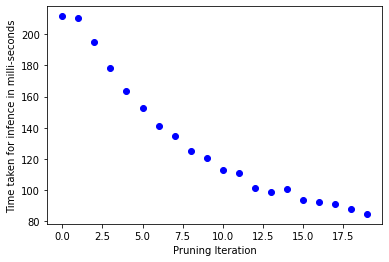

In [ ]:
x = [x for x, _ in ranks_and_times]
y = [y*1000 for _, y in ranks_and_times]

plt.plot(x, y, 'bo')
plt.xlabel("Pruning Iteration")
plt.ylabel("Time taken for infence in milli-seconds")

Text(0, 0.5, 'Accuracy')

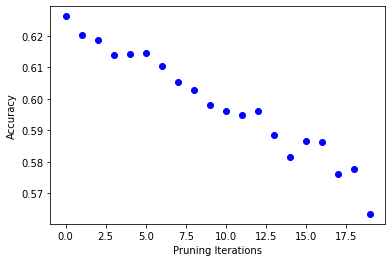

In [ ]:
x = [x for x, _ in ranks_and_accuracies]
y = [y for _, y in ranks_and_accuracies]

plt.plot(x, y, 'bo')
plt.xlabel("Pruning Iterations")
plt.ylabel("Accuracy")

In [ ]:
# TODO: add code for option 1 here

# def depth_separable_net_fn(batch: Batch, width: float) -> jnp.ndarray:

#   x = normalize(batch[0])

#   # Do not alter the architecture code.
#   net = hk.Sequential([
#       # hk.Conv2D(output_channels=3, kernel_shape=(3,3)),
#       # jax.nn.relu,
#       # hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
#       hk.DepthwiseConv2D(1, kernel_shape=5),
#       jax.nn.relu,
#       hk.Conv2D((width * 6*3).astype('int'), kernel_shape=(1, 1)),
#       jax.nn.relu,
#       hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
#       hk.DepthwiseConv2D(1, kernel_shape=5),
#       jax.nn.relu,
#       hk.Conv2D((width * 16*3).astype('int'), kernel_shape=(1, 1)),
#       jax.nn.relu,
#       hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
#       hk.Flatten(),
#       hk.Linear((3000).astype('int')), jax.nn.relu,
#       hk.Linear((2000).astype('int')), jax.nn.relu,
#       hk.Linear((2000).astype('int')), jax.nn.relu,
#       hk.Linear((1000).astype('int')), jax.nn.relu,
#       hk.Linear(10),
#   ])
#   return net(x)

In [ ]:
# import jmp

# policy = jmp.get_policy('params=float16,compute=float16,output=float16')

# ranks_and_accuracies = []
# ranks_and_times = []
# hk.mixed_precision.set_policy(depth_separable_net_fn, policy)
# for width_fraction in np.arange(1.0, 0.0, -1.5):
#   depth_separable_net_fn = partial(depth_separable_net_fn, width=width_fraction)
#   # Quantization, using float 16 during compute and output to speed up training and inference

#   # sampling multiple random numbers together to optimize init and apply of model
#   # depth_separable_net_fn = hk.experimental.optimize_rng_use(depth_separable_net_fn)

#   net = hk.without_apply_rng(hk.transform(depth_separable_net_fn))
#   depth_separable_params = net.init(jax.random.PRNGKey(42), next(train))
#   depth_separable_avg_params = deepcopy(depth_separable_params)

#   opt_state = opt.init(depth_separable_params)

#   print(f"Evaluating the model at " f"{width_fraction:.2f}")

#   # train network
#   opt_state = opt.init(depth_separable_params)

#   # Do not alter the number of steps
#   for step in range(10001):
#     if step % 1000 == 0:
#       val_accuracy, d = compute_accuracy(depth_separable_avg_params, next(validation))
#       test_accuracy, d = compute_accuracy(depth_separable_avg_params, next(test))
#       val_accuracy, test_accuracy = jax.device_get(
#           (val_accuracy, test_accuracy))
#       print(f"[Step {step}] Validation / Test accuracy: "
#             f"{val_accuracy:.3f} / {test_accuracy:.3f}.")

#     depth_separable_params, opt_state = update(depth_separable_params, opt_state, next(train))
#     depth_separable_avg_params = ema_update(depth_separable_params, depth_separable_avg_params)

#   # TODO: modify the compute_eval_metrics function below to compute the time taken for inference.
#   test_accuracy, duration = compute_eval_metrics(depth_separable_avg_params, next(test), 50)
#   ranks_and_times.append((width_fraction, np.mean(duration)))
#   ranks_and_accuracies.append((width_fraction, np.mean(test_accuracy)))
#   print(f"Rank Fraction / Test accuracy: "
#           f"{width_fraction:.2f} / {np.mean(test_accuracy):.3f}.")
#   print(f"Rank Fraction / Duration (milli sec): "
#           f"{width_fraction:.2f} / {np.mean(duration)*1000:.4f}.")

## You have made it to the end of the challenge!

Before you submit your completed challenge document, please make sure to **save and pin your revisions** before submitting a link to your submission via the [Cohere For AI Scholars Program Application.](https://jobs.lever.co/cohere/)